# Exercise 3: Linear Support Vector Machines


## I. GOAL OF THE EXERCISE

The main goal is to understand the SVM classifier and the particularities of the solution achieved. For that purpose we will code the linear SVM from scratch using a QP solver at the optimization step.

## II. DELIVERABLES
As you progress in this exercise, you will find several questions. You are expected to answer them properly with adequate figures when required and deliver a document with all these evidences in due time. A file or files with the working code used for generating and discussing the results must be also delivered.




<div class = "alert alert-danger" style="border-radius:10px"> **IMPORTANT:** Write in the next cell the name of the people that answer this notebook
</div>

## Salvador Medina Herrera, Johannes Heidecke

In this exercise we will use a convex optimization solver (cvxpy) so we won't need to code the optimization process. You can find the installation instructions at

http://www.cvxpy.org/en/latest/




## III. CODE DESIGN

All classifiers must be coded from scratch, no toolkits are allowed to be used except for CVX (see details in the next section). 

## IV. INTRODUCTION TO THE TOOLS

The support vector machine defines a quadratic programming problem. Solving efficiently the problem is out of the scope of this course. For this reason, you are welcomed to use CVX convex optimization toolbox (http://www.cvxpy.org/en/latest/). This toolbox allows to solve many convex optimization problems of medium size, i.e. linear, quadratic, cone, geometric and semi-definite programming problems. The toolbox allows to use user friendly notation for writing the convex optimization problem. E.g. given the following problem

$$
\begin{align}
\underset{x}{\text{minimize}} & \quad \|Ax-b\|^2\\
\text{subject to} & \quad \|x\|_{\infty}\leq 1
\end{align}
$$


the next CVX code corresponds to the optimization of the former problem:

In [1]:
%reset -f
from cvxpy import *
import numpy as np

# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
C = np.random.randn(m, n)
b = np.random.randn(m)
d = np.random.randn(m)

# Construct the problem.
x = Variable(n)
objective = Minimize(sum_squares(A*x - b))
constraints = [norm(x,"inf") <= 1]
prob = Problem(objective, constraints)


# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
# print x.value
# Check the status of the solution (Infeasible, Optimal)
print prob.status

optimal


Please, refer to the reference documentation for additional details. 

<div class = "alert alert-info" style = "border-radius:10px">
**HINTS: ** Some operations are overridden such as `*` that performs matrix multiplication. If you need to do an element-wise multiplication you can use `mul_elemwise`. Additionally, `sum_entries` and `norm` can be useful for your code development.
</div>


## V. UNDERSTANDING SUPPORT VECTOR MACHINES
### A. Understanding the primal
Code the primal problem for hard margin linear SVM (i.e. without slack variables) using CVX. It is recommended to clear your workspace before running the CVX code.

The primal problem hard margin linear SVM is 

$$
\begin{align}
\underset{a,b}{\text{minimize}} & \quad \|a\|_2\\
\text{subject to} & \quad y_i (a^Tx_i+ b) \geq 1, \forall i
\end{align}
$$

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 1:**
<ol>
<li>Load the dataset `example_dataset_1.mat`.</li>
<li>Run your training algorithm on that dataset.</li>
<li>Plot the dataset and the separating hyperplane.</li>
<li>Identify the support vectors and explain how you know they are support vectors.</li>
</ol>

</div>


In [2]:
%reset -f

# Question 1-1:
import scipy.io as sio
data = sio.loadmat('example_dataset_1.mat')
X = data['data'].T
y = data['labels'].astype(float)

In [3]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

# Question 1-2:
a = cvx.Variable(X.shape[1])
b = cvx.Variable()

# define objective and constraints:
objective   = cvx.Minimize(cvx.norm(a, 2))
constraints = [cvx.mul_elemwise(y, (X * a + b)) >= 1]
# solve the problem:
problem = cvx.Problem(objective, constraints)
problem.solve()

print "Status:", problem.status
print "Optimal value for ||a||: ", problem.value
print "Distance between hyperplanes: ", 2/problem.value
print "a: ", a.value.T
print "b: ", b.value



Status: optimal
Optimal value for ||a||:  9.09650430934
Distance between hyperplanes:  0.219864679001
a:  [[ 7.69503545 -4.85106382]]
b:  0.975177304056


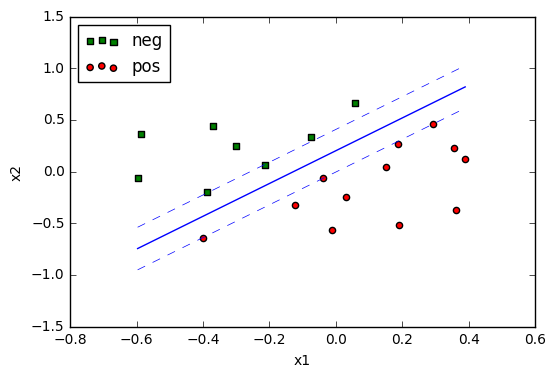

In [4]:
# Question 1-3:
def plotSvmResult(X, y, curves, SV=None, margins=False):
    nRows = np.where(np.less(y, 0))[0]
    pRows = np.where(np.greater(y, 0))[0]
    nX = X[nRows, :]
    pX = X[pRows, :]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    # plot the data points according to their class:
    ax1.scatter(nX[:, 0], nX[:, 1], s=20, c='g', marker="s", label='neg')
    ax1.scatter(pX[:, 0], pX[:, 1], s=20, c='r', marker="o", label='pos')
    if SV is not None:
        nSV = np.intersect1d(SV, nRows)
        ax1.scatter(X[nSV, 0], X[nSV, 1], s=20, c='b', marker="s", label='neg sv')
        pSV = np.intersect1d(SV, pRows)
        ax1.scatter(X[pSV, 0], X[pSV, 1], s=20, c='b', marker="o", label='pos sv')
    for curve in curves:
    # plot the hyperplane
    # a*x + b = 0 <=> x2 = (-a1/a2)x1 - b/a2
        slope = -curve[0].value[0]/curve[0].value[1]
        x1s = np.array([min(X[:, 0]), max(X[:, 0])])
        x2s = np.multiply(x1s, slope)
        x2s = np.add(x2s, -curve[1].value/curve[0].value[1]).tolist()[0]
        plt.plot(x1s, x2s, c=curve[3], label=curve[2])
        if margins:
            x2sL = np.add(x2s, 1.0/curve[0].value[1]).tolist()[0]
            plt.plot(x1s, x2sL, c = curve[3], ls='dashed', lw=0.5)
            x2sU = np.add(x2s, -1.0/curve[0].value[1]).tolist()[0]
            plt.plot(x1s, x2sU, c = curve[3], ls='dashed', lw=0.5)
    
    
        
        
    plt.legend(loc='upper left');
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    plt.show()

plotSvmResult(X, y, [(a,b,'','b')], margins=True)

The support vectors are the following points:
[[-0.21428571  0.06725146]
 [-0.03917051 -0.06725146]
 [ 0.29262673  0.45906433]]


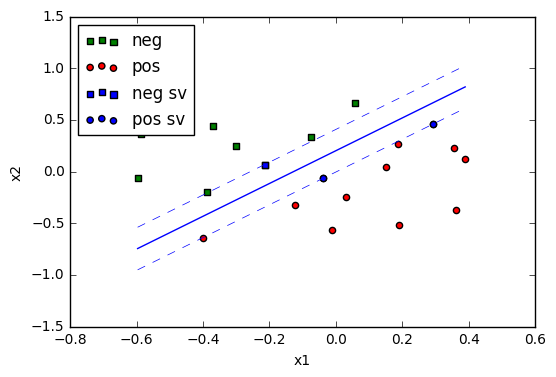

In [5]:
# Question 1-4:

# The support vectors are the points that fullfill the condition
# aT * x + b = |1|
yResult =  np.add(X.dot(a.value), b.value)
supportVectorRows = np.where(np.isclose(np.abs(yResult), 1))[0]

print 'The support vectors are the following points:'
print X[supportVectorRows, :]

# plot the support vectors:
plotSvmResult(X, y, [(a,b,'','b')], SV=supportVectorRows, margins=True)

### B. Soft-margin linear SVM

Code the primal problem for the soft-margin linear SVM using CVX. The soft-margin linear SVM is as follows

$$
\begin{align}
\underset{a,b}{\text{minimize}} & \quad \|a\|_2 + C \sum_i \xi_i\\
\text{subject to} & \quad y_i (a^Tx_i+ b) \geq 1 - \xi_i, \forall i\\
& \quad \xi_i \geq 0
\end{align}
$$

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 2:**
<ol>
<li>Load the dataset ’example_dataset_1.mat’.</li>
<li>Consider the soft-margin formulation for C = 0. Is it reasonable to think that the
resulting hyperplane should be very similar to the case of hard-margin SVM in
a separable problem? Why?</li>
<li>Run the training algorithm for non-separable datasets with C=0. Plot the dataset
and the separating hyperplane. What do you observe? Hypothesize a reasonable
explanation.</li>
<li>Plot the dataset and the separating hyperplane when training with C = 1e − 2,
C=1 and C=1e2.</li>
<li>Which is the expected value of $\xi_i$ for the support vectors with margin equals 1?</li>
<li>Observe the values of $\xi_i$ for $C = 1$. Can you identify the SVs by observing
those values? Describe the rule you use for identifying them.</li>
</ol>
</div>

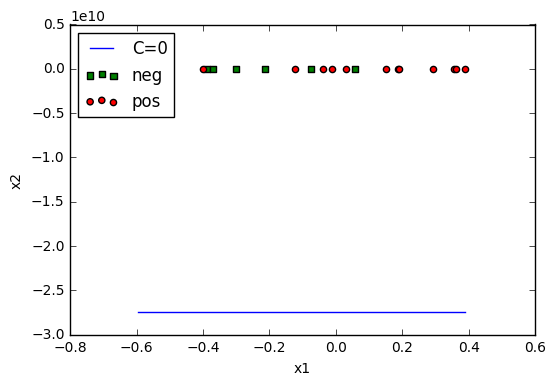

In [6]:
# Question 2-1:
import scipy.io as sio
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
data = sio.loadmat('example_dataset_1.mat')
X = data['data'].T
y = data['labels'].astype(float)

# Question 2-2:
# It is not reasonable to think that, as the condition are very different
# If we set C to 0, the function to minimize is the exact same as in the hard-margin SVM:
# cvx.norm(a, 2)
# The condition is a little different though, cvx.mul_elemwise(y, (X * a + b)) >= 1 - eps
# Where eps is an array where all elements are >= 0. Epsilon is not in the minimization 
# function and the only condition for it is being bigger than 0. This makes the constraint
# useless for optimization. It will simply not work.

# Question 2-3
def softMarginSolve(X,y,C):
    eps = cvx.Variable(y.shape[0])
    a = cvx.Variable(X.shape[1])
    b = cvx.Variable()

    objective   = cvx.Minimize(cvx.norm(a, 2)+C*sum(eps))
    constraints = [cvx.mul_elemwise(y, (X * a + b)) >= 1-eps, eps >= 0]

    prob = cvx.Problem(objective, constraints)
    prob.solve()
    return (prob,a,b,eps)

(prob,a,b,eps) = softMarginSolve(X,y,0)
plotSvmResult(X,y,[(a,b,'C=0','b')])

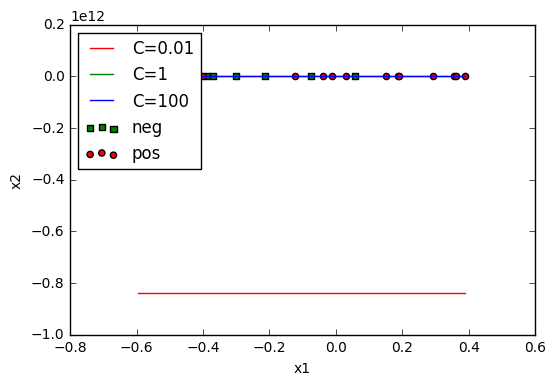

In [7]:
# Question 2-4
res001 = softMarginSolve(X,y,0.01)
res1 = softMarginSolve(X,y,1)
res100 = softMarginSolve(X,y,100)
plotSvmResult(X,y,[
        (res001[1], res001[2],'C=0.01', 'r'),
        (res1[1], res1[2], 'C=1', 'g'), 
        (res100[1], res100[2], 'C=100', 'b')])

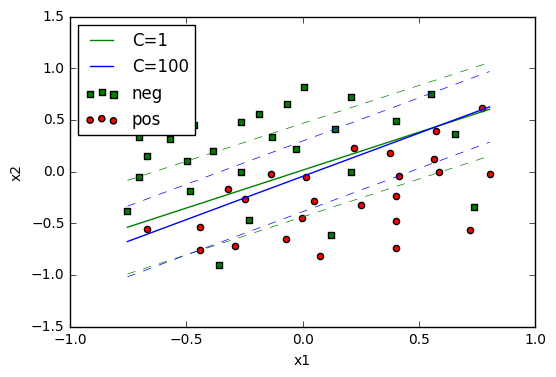

In [13]:
# The C=0.01 line is so far from the actual points that the plot is not visible
# at all. The following plot shows just the C=1 and C=100 lines

plotSvmResult(X,y,[
        (res1[1], res1[2], 'C=1', 'g'), 
        (res100[1], res100[2], 'C=100', 'b')], margins=True)

0.170495525526


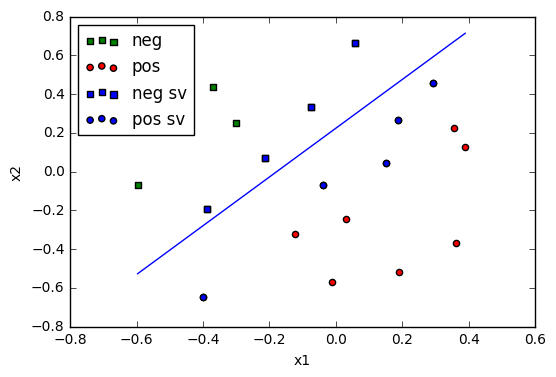

In [9]:
# Question 2-5
# When the margin equals 1, the expected value of xi is 0

# Question 2-6
# Maybe the top 3 highest eps_i?


yResult =  np.multiply(np.add(X.dot(res1[1].value), res1[2].value), y)

# print np.round(np.hstack((res1[3].value,yResult)), 5)

supportVectorRows = np.where(np.round(yResult, 4) <= 1)[0]

plotSvmResult(X, y, [(res1[1], res1[2],'','b')], SV=supportVectorRows)

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 3:**
<ol>
<li>Load the dataset ’example_dataset_2.mat’.</li>
<li>Run your training algorithm on that dataset for C = 1e−2, C = 1 and C = 1e2.</li>
<li>Plot the dataset and the separating hyperplane for each value of lambda.</li>
<li>Observe the values of ui for C = 100. Can you identify the SVs simply by
observing those values? Describe the rule you use for identifying them.</li>
</ol>
</div>


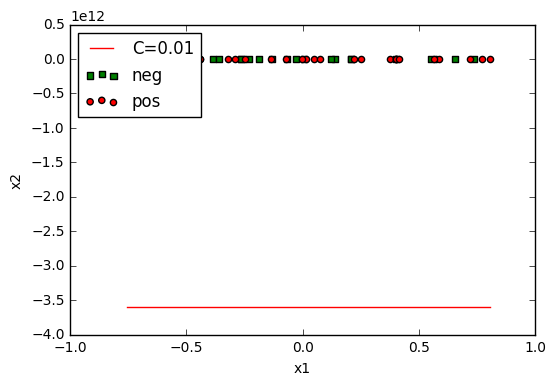

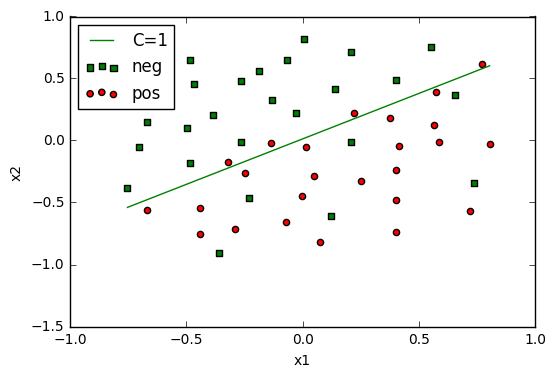

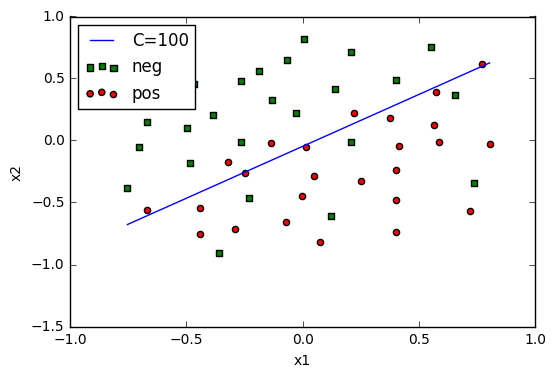

In [10]:
# Question 3-1
data = sio.loadmat('example_dataset_2.mat')
X = data['data'].T
y = data['labels'].astype(float)

# Question 3-2
res001 = softMarginSolve(X,y,0.01)
res1 = softMarginSolve(X,y,1)
res100 = softMarginSolve(X,y,100)

# Question 3-3
plotSvmResult(X,y,[
        (res001[1], res001[2],'C=0.01', 'r')])
plotSvmResult(X,y,[
        (res1[1], res1[2], 'C=1', 'g')])
plotSvmResult(X,y,[
        (res100[1], res100[2], 'C=100', 'b')])

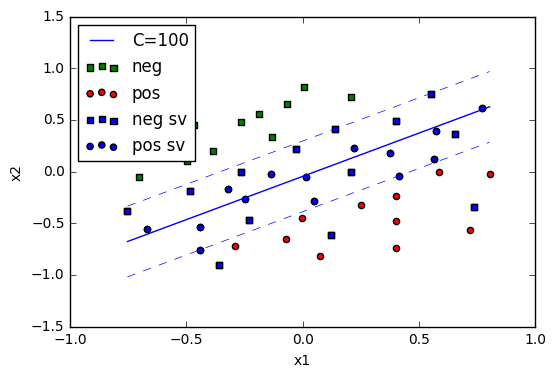

In [11]:
# Question 3-4:


yResult =  np.multiply(np.add(X.dot(res100[1].value), res100[2].value), y)

# print np.round(np.hstack((res100[3].value,yResult)), 5)

supportVectorRows = np.where(np.round(yResult, 4) <= 1)[0]

# print X[supportVectorRows, :]

plotSvmResult(X, y, [(res100[1], res100[2],'C=100','b')], SV=supportVectorRows, margins=True)


## C. Unbalanced data
In this section we will vary the formulation of SVM to handle unbalanced data. Suppose that in this problem data with label −1 is critical, e.g. examples from a rare disease, machine failure, etc.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 4:**
<ol>
<li>Load the dataset ’example_dataset_3.mat’.</li>
<li>Check how many examples we have for each class. Is the problem unbalanced?
Why?</li>

<li>Search for the optimum value of C for this problem. Plot the separating
hyperplane and justify your choice of C.</li>

<li>Is the result satisfying? Why?</li>
<li>Compute and report the training error rate.</li>
</ol>
</div>


In general, the cost of an error in a critical class is set by the user/client according to the application. However if we don’t have a priori knowledge it is sensible to use a balancing weight so that an error on the majority class has less importance. A possible balancing weight is to use the quotient between the cardinality of the minority class set over the cardinality of the majority class set.

**HINT: ** We can divide the original SVM optimization problem in the following:

$$
\begin{align}
\underset{a,b}{\text{minimize}} & \quad \|a\|_2 + C (\sum_i u_i + \sum_i v_i),\\
\text{subject to} & \quad a^Tx_i+ b \geq 1 - u_i, \; i: y_i = +1,\\
& \quad a^Tx_i+ b \leq -1 + v_i, \; i: y_i = -1,\\ 
& \quad u_i\geq 0,\\
& \quad v_i\geq 0.
\end{align}
$$

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 5:**
<ol>
<li>Modify your code to take into account balancing weights between the misclassifications of class +1 and class -1. This weight value must trade-off both misclassification errors. Hint: instead of using the compact constraint $y_i(a^T x_i + b) \geq 1 − \xi_i$, use separate constraints for the class +1 and −1. Look at the first slides regarding A convex optimization view to linear classification.</li>

<li> Set the balancing weights so that one error in the minority class accounts for the ratio between the majority and the minority classes. Search for the optimum value of C for this problem. Plot the separating hyperplane and justify your choice of C.</li>

<li>Is the result satisfying? Why?</li>

<li>Compute and report the error rate. Is this error rate smaller than the one obtained
in block 4? Why?</li>

<li>Use the balancing weight to define a weighted error rate and compute the weighed
training error rates for the models in block 4. Is this error rate smaller than the weighed error for the model in block 4? Why?</li>
</ol>
</div>


In [12]:
#your code here